# Order - LocalQl, LocalWl
The `freud.order` module provids the tools to calculate various [order parameters](https://en.wikipedia.org/wiki/Phase_transition#Order_parameters) that can be used to identify phase transitions.
In the context of crystalline systems, some of the best known order parameters are the Steinhardt order parameters $Q_l$ and $W_l$.
These order parameters are mathematically defined according to certain rotationally invariant combinations of spherical harmonics calculated between particles and their nearest neighbors, so they provide information about local particle environments.
As a result, considering distributions of these order parameters across a system can help characterize the overall system's ordering.
The primary utility of these order parameters arises from the fact that they often exhibit certain characteristic values for specific crystal structures.

In this notebook, we will use the order parameters to identify certain basic structures: BCC, FCC, and simple cubic.
FCC, BCC, and simple cubic structures each exhibit characteristic values of $Q_l$ for some $l$ value, meaning that in a perfect crystal all the particles in one of these structures will have the same value of $Q_l$.
As a result, we can use these characteristic $Q_l$ values to determine whether a disordered fluid is beginning to crystallize into one structure or another.
The $l$ values correspond to the $l$ quantum number used in defining the underlying spherical harmonics; for example, the $Q_4$ order parameter would provide a measure of 4-fold ordering. 

In [1]:
import freud
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import util
# Try to plot using KDE if available, otherwise revert to histogram
try:
    from sklearn.neighbors.kde import KernelDensity
    kde = True
except:
    kde = False

In [2]:
%matplotlib inline

We first construct ideal crystals and then extract the characteristic value of $Q_l$ for each of these structures.
Note that we are using the `LocalQlNear` class, which takes as a parameter the number of nearest neighbors to use in additional to a distance cutoff.
The base `LocalQl` class can also be used, but it can be much more sensitive to the choice of distance cutoff; conversely, the corresponding `LocalQlNear` class is guaranteed to find the number of neighbors required.
Such a guarantee is especially useful when trying to identify known structures that have specific coordination numbers.
In this case, we know that simple cubic has a coordination number of 6, BCC has 8, and FCC has 12, so we are looking for the values of $Q_6$, $Q_8$, and $Q_{12}$, respectively.
Therefore, we can also enforce that we require 6, 8, and 12 nearest neighbors to be included in the calculation, respectively.

In [3]:
r_max = 2

L = 6
box, sc = util.make_sc(5, 5, 5)
# The last two arguments are the quantum number l and the number of nearest neighbors.
ql = freud.order.LocalQlNear(box, r_max*2, L, L)
Ql_sc = ql.compute(sc).Ql
mean_sc = np.mean(Ql_sc)
print("The standard deviation in the values computed for simple cubic is {}".format(np.std(Ql_sc)))

L = 8
box, bcc = util.make_bcc(5, 5, 5)
ql = freud.order.LocalQlNear(box, r_max*2, L, L)
Ql_bcc = ql.compute(bcc).Ql
mean_bcc = np.mean(Ql_bcc)
print("The standard deviation in the values computed for BCC is {}".format(np.std(Ql_bcc)))

L = 12
box, fcc = util.make_fcc(5, 5, 5)
ql = freud.order.LocalQlNear(box, r_max*2, L, L)
Ql_fcc = ql.compute(fcc).Ql
mean_fcc = np.mean(Ql_fcc)
print("The standard deviation in the values computed for FCC is {}".format(np.std(Ql_fcc)))

The standard deviation in the values computed for simple cubic is 1.5993604662867256e-08
The standard deviation in the values computed for BCC is 2.5410740178699598e-08
The standard deviation in the values computed for FCC is 7.753187247772075e-08


Given that the per-particle order parameter values are essentially identical to within machine precision, we can be confident that we have found the characteristic value of $Q_l$ for each of these systems.
We can now compare these values to the values of $Q_l$ in thermalized systems to determine the extent to which they are exhibiting the ordering expected of one of these perfect crystals.

In [4]:
def make_noisy_replicas(points, variances):
    """Given a set of points, return an array of those points with noise."""
    point_arrays = []
    for v in variances:
        point_arrays.append(
            points + np.random.multivariate_normal(
                mean=(0, 0, 0), cov=v*np.eye(3), size=points.shape[0]))
    return point_arrays

In [5]:
variances = [0.005, 0.01, 1]
sc_arrays = make_noisy_replicas(sc, variances)
bcc_arrays = make_noisy_replicas(bcc, variances)
fcc_arrays = make_noisy_replicas(fcc, variances)

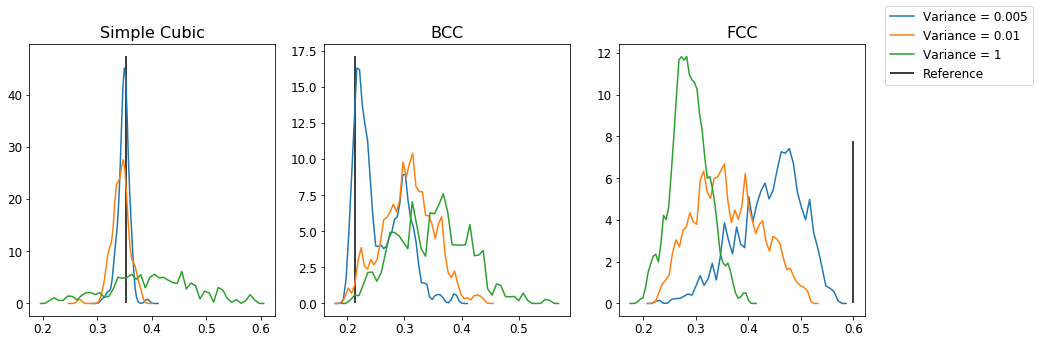

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Zip up the data that will be needed for each structure type.
zip_obj = zip([sc_arrays, bcc_arrays, fcc_arrays], [mean_sc, mean_bcc, mean_fcc],
              [6, 8, 12], ["Simple Cubic", "BCC", "FCC"])

for i, (arrays, ref_val, L, title) in enumerate(zip_obj):
    ax = axes[i]
    for j, (array, var) in enumerate(zip(arrays, variances)):
        ql = freud.order.LocalQlNear(box, r_max*2, L, L)
        ql.compute(array)
        if not kde:
            ax.hist(ql.Ql, label="Variance = {}".format(var), density=True)
        else:
            padding = 0.02
            N = 50
            bins = np.linspace(np.min(ql.Ql)-padding, np.max(ql.Ql)+padding, N)
            
            kde = KernelDensity(bandwidth=0.004)
            kde.fit(ql.Ql[:, np.newaxis])
            Ql = np.exp(kde.score_samples(bins[:, np.newaxis]))
            
            ax.plot(bins, Ql, label="Variance = {}".format(var))
        ax.set_title(title, fontsize=16)
        ax.tick_params(axis='both', which='both', labelsize=12)
        if j == 0:
            # Can choose any element, all are identical in the reference case
            ax.vlines(ref_val, 0, np.max(ax.get_ylim()[1]), label='Reference')
fig.legend(*ax.get_legend_handles_labels(), fontsize=12);  # Only have one legend
fig.subplots_adjust(right=0.85)

From this figure, we can see that for each type of structure, increasing the amount of noise makes the distribution of the order parameter values less peaked at the expected reference value.
As a result, we can use this method to identify specific structures.
However, you can see even from these plots that the measures are not always good; for example, the BCC example shows minimal distinction between variances of $0.01$ and $1$, which you might hope to be easily distinguishable, while adding minimal noise to the FCC crystals makes the system deviate substantially from the optimal value of the order parameter.
As a result, choosing the appropriate parameterization for the order parameter (which quantum number $l$ to use, how many nearest neighbors, the $r_{cut}$, etc) can be very important.

In addition to the simple `LocalQlNear` class demonstrated here and the $r_{cut}$ based `LocalQl` variant, there are also the `LocalWl` and `LocalWlNear` classes.
The latter two classes use the same spherical harmonics to compute a slightly different quantity: $Q_l$ involves one way of averaging the spherical harmonics between particles and their neighbors, and $W_l$ uses a different type of average.
The $W_l$ averages may be better at identifying some structures, so some experimentation and reference to the appropriate literature can be useful (as a starting point, see [Steinhardt's original paper](https://doi.org/10.1103/PhysRevB.28.784)).

In addition to the difference between the classes, the classes also contain additional compute methods that perform an additional type of averaging.
Calling `computeAve` instead of compute will populate the `ave_Ql` (or `ave_Wl`) arrays, which perform an additional level of implicit averaging over the second neighbor shells of particles to accumulate more information on particle environments (see the [original reference](https://doi.org/10.1063/1.2977970)).
To get a sense for the best method for analyzing a specific system, the best course of action is try out different parameters or to consult the literature to see how these have been used in the past.